In [56]:
import cv2
import pandas as pd
import glob
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import mean_squared_error

In [12]:
path = "input/FER"

faceFiles = [
    *glob.glob(f"../{path}/train/**/*.jpg")
]
faceFiles

['../input/FER/train/happy/S085_002_00000013.jpg',
 '../input/FER/train/happy/S011_006_00000013.jpg',
 '../input/FER/train/happy/S060_002_00000025.jpg',
 '../input/FER/train/happy/S137_011_00000020.jpg',
 '../input/FER/train/happy/S037_006_00000020.jpg',
 '../input/FER/train/happy/S124_007_00000024.jpg',
 '../input/FER/train/happy/S037_006_00000021.jpg',
 '../input/FER/train/happy/S116_007_00000015.jpg',
 '../input/FER/train/happy/S060_002_00000024.jpg',
 '../input/FER/train/happy/S011_006_00000012.jpg',
 '../input/FER/train/happy/S085_002_00000012.jpg',
 '../input/FER/train/happy/S109_006_00000013.jpg',
 '../input/FER/train/happy/S092_004_00000023.jpg',
 '../input/FER/train/happy/S060_002_00000026.jpg',
 '../input/FER/train/happy/S064_003_00000025.jpg',
 '../input/FER/train/happy/S089_002_00000021.jpg',
 '../input/FER/train/happy/S095_007_00000019.jpg',
 '../input/FER/train/happy/S134_004_00000014.jpg',
 '../input/FER/train/happy/S116_007_00000017.jpg',
 '../input/FER/train/happy/S068

In [13]:
print(len(faceFiles))

981


In [14]:
pics = dict()
for foto in faceFiles:
    label = foto.split("/")[-2]
    pic = foto
    if label in pics:
        pics[label].append(pic)
    else:
        pics[label] = [pic]

In [15]:
im = []
for k,v in pics.items():
    for a in v:
        im.append([k,a])
faces_df =  pd.DataFrame(im, columns=["mood","photo"])
display(faces_df)

,mood,photo
0,happy,../input/FER/train/happy/S085_002_00000013.jpg
1,happy,../input/FER/train/happy/S011_006_00000013.jpg
2,happy,../input/FER/train/happy/S060_002_00000025.jpg
3,happy,../input/FER/train/happy/S137_011_00000020.jpg
4,happy,../input/FER/train/happy/S037_006_00000020.jpg
...,...,...
976,disgust,../input/FER/train/disgust/S128_004_00000011.jpg
977,disgust,../input/FER/train/disgust/S068_005_00000021.jpg
978,disgust,../input/FER/train/disgust/S056_002_00000009.jpg
979,disgust,../input/FER/train/disgust/S077_006_00000014.jpg


In [16]:
import random
who = random.choice(faces_df.mood)
missing = pics[who]

In [17]:
faces_df.mood.value_counts()

surprise    249
happy       207
disgust     177
anger       135
sadness      84
fear         75
contempt     54
Name: mood, dtype: int64

[(2, 7, 43, 41)]


array([[ 11,  13,  25, ...,  47,  20,  13],
       [  9,  14,  22, ...,  76,  34,  17],
       [ 10,  18,  27, ...,  99,  49,  27],
       ...,
       [147, 146, 148, ..., 162, 163, 163],
       [146, 145, 147, ..., 163, 163, 162],
       [142, 144, 146, ..., 146, 156, 163]], dtype=uint8)

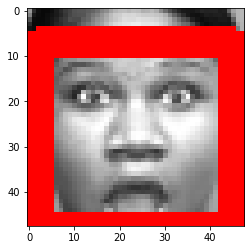

In [18]:
import matplotlib.pyplot as plt
import cv2
import face_recognition

face_cascade = cv2.CascadeClassifier('./haarcascade_frontalface_default.xml')

def extractFace(picFile, method="recognition", debug=False):
    im = cv2.imread(picFile)    
    im_bw = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
    plt.imshow(im_bw, cmap="gray")
    # Face detection, OJO: esto detecta multiples caras
    if method == "recognition":
        faces = face_recognition.face_locations(im_bw)
        faces = [(l,t,r-l,b-t) for t,r,b,l in faces]
    else:
        faces = face_cascade.detectMultiScale(im_bw, 2, 4)

    if len(faces) == 0:
        print(f"Warning: no face detected on {picFile}")
        return 
    
    if debug:
        print(faces)
    selected_face = faces[0]
    discard_faces = faces[1:]
    
    if debug:
        debug_squares = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        # plot the invalid squares in blue
        for face in discard_faces:
            x,y,w,h = face
            debug_squares = cv2.rectangle(debug_squares, (x,y), (x+w,y+h),(0, 0, 255) ,5)
        # plot the selected face in red
        x,y,w,h = selected_face
        debug_squares = cv2.rectangle(debug_squares, (x,y), (x+w,y+h),(255, 0, 0) ,5)

        plt.imshow(debug_squares)

            
    # extract selected face as B&W 
    x,y,w,h = selected_face
    cara = im_bw[y:y+h,x:x+h]    
    return cara

    
    
    
extractFace(missing[1], debug=True)

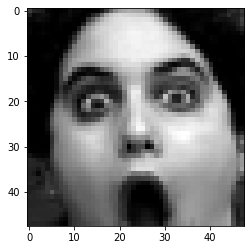

In [19]:
missingFaces = [extractFace(missingPic) for missingPic in missing]


In [20]:
missingFaces = [a for a in missingFaces if isinstance(a, np.ndarray)]

In [21]:
dim = (100,100)
missingNormalized = [cv2.resize(a, dim, interpolation=cv2.INTER_AREA) for a in missingFaces]

In [22]:
[a.shape for a in missingNormalized]

[(100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),
 (100, 100),

In [23]:
# Wrap all in one fn
def processFiles(files, dim=(100,100)):
    output_faces = []
    for incomingFile in files: 
        face = extractFace(incomingFile)
        if  isinstance(face, np.ndarray):
            face = cv2.resize(face, dim, interpolation=cv2.INTER_AREA)
            output_faces.append(face)
    return output_faces


array([-0.10641047,  0.0870547 ,  0.02804225, -0.04332177, -0.17832001,
        0.08417175, -0.0686833 , -0.04548797,  0.10044286, -0.094118  ,
        0.23064086,  0.03124556, -0.25057599, -0.05568452, -0.04970932,
        0.12615335, -0.112097  , -0.15817681, -0.02816101, -0.08039284,
        0.05598371,  0.04927396, -0.01348814,  0.06257585, -0.13716979,
       -0.28743249, -0.08958846, -0.03928459,  0.12529768, -0.14375035,
       -0.06378892,  0.04190597, -0.16479406, -0.00884619,  0.00073901,
        0.03368791, -0.09464397, -0.06690432,  0.21052277,  0.03234519,
       -0.15560716,  0.11811036,  0.01951377,  0.30617118,  0.1498787 ,
        0.01953399,  0.04257293, -0.0813684 ,  0.12389825, -0.31420547,
        0.10322771,  0.13067889,  0.16227204,  0.04988815,  0.06206308,
       -0.25866735, -0.03364936,  0.15246657, -0.1702632 ,  0.14099464,
       -0.04675555, -0.07982625,  0.02282763, -0.12339194,  0.18871251,
        0.13623348, -0.07498136, -0.18209743,  0.19697674, -0.13

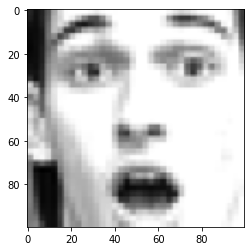

In [24]:
import face_recognition

def extractFeatures(faceIm, useFeats="face",debug=False):
    if debug:
        plt.figure()
        plt.imshow(faceIm, cmap="gray")
    if useFeats == "fft":
        fft2d = np.log(np.abs(np.fft.fft2(faceIm)))
        fft2d = fft2d[0:len(fft2d)//2,0:len(fft2d)//2]
        fft2d = fft2d[5:20,5:20]
        
        if debug:
            plt.figure()
            plt.imshow(fft2d, cmap="gray")
            print(fft2d.shape)
        
        return np.hstack(fft2d)
    elif useFeats == "face":
        imcol = cv2.cvtColor(faceIm, cv2.COLOR_GRAY2RGB)
        feats = face_recognition.face_encodings(imcol)
        if len(feats) > 0:
            return feats[0]
        return None
    
extractFeatures(missingNormalized[0], debug=True)

Processing happy....
Processing contempt....
Processing fear....
Processing surprise....
Processing sadness....
Processing anger....
Processing disgust....


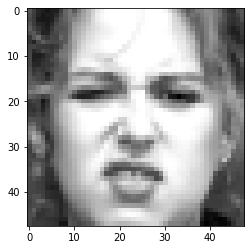

In [25]:
featurized_dataset = []
for mood,photo in pics.items():
    faces = processFiles(photo)
    print(f"Processing {mood}....")
    for i,face in enumerate(faces):
        featurized_dataset.append({
            "mood":mood,
            "picName":i,
            "feats":extractFeatures(face)
        })

In [26]:
df = pd.DataFrame(featurized_dataset)
df

,mood,picName,feats
0,happy,0,"[-0.0857856497168541, 0.12070325762033463, 0.0..."
1,happy,1,"[-0.11561565101146698, 0.10042160749435425, 0...."
2,happy,2,"[-0.08078758418560028, 0.0004498511552810669, ..."
3,happy,3,"[-0.1381092220544815, 0.04767180234193802, 0.1..."
4,happy,4,"[-0.05357274413108826, 0.08892941474914551, 0...."
...,...,...,...
976,disgust,172,"[-0.09853385388851166, 0.03188201040029526, -0..."
977,disgust,173,"[-0.1351788192987442, -0.017433062195777893, 0..."
978,disgust,174,"[-0.12328560650348663, 0.09153527021408081, -0..."
979,disgust,175,"[-0.2434164434671402, 0.08779747039079666, 0.0..."


In [30]:
df.mood.value_counts()

surprise    249
happy       207
disgust     177
anger       135
sadness      84
fear         75
contempt     54
Name: mood, dtype: int64

In [32]:
df = df[~df.feats.isna()]

In [34]:
df.feats.isna().value_counts()

False    978
Name: feats, dtype: int64

In [39]:
y = df.mood
X = np.vstack(df.feats)

In [40]:
print(X.shape,y.shape)

(978, 128) (978,)


In [42]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_numeric = le.fit_transform(y)
y_numeric

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y_numeric, test_size=0.2)

In [47]:
model = KNeighborsClassifier()

model.fit(X_train, y_train)

KNeighborsClassifier()

In [49]:
model.predict(X_test)

array([0, 3, 1, 3, 6, 6, 2, 2, 3, 2, 0, 3, 0, 0, 6, 2, 4, 5, 0, 5, 5, 5,
       3, 2, 2, 2, 6, 4, 0, 6, 1, 6, 0, 6, 5, 4, 4, 1, 3, 4, 0, 3, 0, 4,
       4, 3, 2, 2, 6, 2, 2, 2, 5, 0, 4, 0, 2, 6, 0, 4, 3, 0, 3, 2, 0, 2,
       5, 0, 4, 4, 5, 6, 0, 3, 5, 6, 2, 0, 3, 0, 5, 2, 3, 0, 0, 0, 6, 4,
       4, 2, 6, 4, 4, 2, 2, 6, 1, 0, 4, 0, 2, 1, 4, 4, 3, 6, 4, 4, 6, 0,
       0, 5, 3, 6, 1, 0, 3, 6, 4, 3, 4, 5, 2, 2, 2, 4, 1, 0, 3, 2, 4, 2,
       4, 6, 5, 0, 3, 2, 2, 0, 6, 2, 3, 3, 2, 4, 5, 3, 3, 0, 6, 6, 0, 5,
       0, 1, 1, 4, 4, 3, 2, 3, 3, 2, 2, 6, 4, 5, 5, 4, 3, 6, 6, 2, 0, 4,
       2, 4, 0, 0, 0, 6, 0, 4, 6, 2, 0, 3, 0, 1, 4, 5, 3, 0, 2, 5])

In [54]:
y_pred = model.predict(X_test)
pd.DataFrame({
    "pred": le.inverse_transform(y_pred),
    "real": le.inverse_transform(y_test)
})

,pred,real
0,anger,sadness
1,fear,surprise
2,contempt,contempt
3,fear,surprise
4,surprise,happy
...,...,...
191,sadness,fear
192,fear,happy
193,anger,anger
194,disgust,disgust


In [59]:
print(mean_squared_error(y_test, y_pred, squared=False))

2.3754698783308417


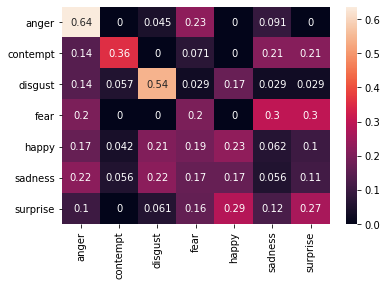

In [52]:
cm = confusion_matrix(le.inverse_transform(y_test), le.inverse_transform(y_pred), normalize="true")
sns.heatmap(cm, annot=True,xticklabels=le.classes_, yticklabels=le.classes_)

In [53]:
le.classes_

array(['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness',
       'surprise'], dtype=object)